In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 14.4 MB/s eta 0:00:00


In [ ]:
import numpy as np

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import pickle

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import pandas as pd

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras import layers, models, optimizers, callbacks

In [ ]:
class vis_transformer:
    def __init__(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

        (_, self.image_size, _, c) = np.shape(self.x_train)
        self.input_shape = (self.image_size, self.image_size, c)
        self.label_size = np.shape(y_train)[1]
        self.patch_size = 13
        self.num_patches = (self.image_size // self.patch_size) ** 2

        self.projection_dim = 96
        self.num_heads = 4
        self.transformer_units = [self.projection_dim * 2, self.projection_dim]
        self.transformer_layers = 16
        self.mlp_head_units = [2048, 1024]


#    def augmentation(self):

#        """this function is an object function to do data augmentation"""

#        data_augmentation = keras.Sequential(
#            [
#                tf.keras.layers.experimental.preprocessing.Normalization(),
#                tf.keras.layers.experimental.preprocessing.RandomRotation(factor=0.02),
#                tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2),
#            ], name="data_augmentation",)

        # Compute the mean and the variance of the training data for normalization.
#        data_augmentation.layers[0].adapt(self.x_train)





    def mlp(self, x, hidden_units, dropout_rate):
        for units in hidden_units:
            x = layers.Dense(units, activation=tf.nn.gelu)(x)
            x = layers.Dropout(dropout_rate)(x)
        return x



    def get_patches(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches



    def get_patchencoder(self, patch):
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = layers.Embedding(input_dim=self.num_patches, output_dim=self.projection_dim)
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

    def create_model(self):
        inputs = layers.Input(shape=(self.image_size, self.image_size, 1))
        patches = self.get_patches(inputs)
        encoded_patches = self.get_patchencoder(patches)

        for _ in range(self.transformer_layers):
            x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
            attention_output = layers.MultiHeadAttention(num_heads=self.num_heads, key_dim=self.projection_dim, dropout=0.1)(x1, x1)
            x2 = layers.Add()([attention_output, encoded_patches])
            x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
            x3 = self.mlp(x3, hidden_units=self.transformer_units, dropout_rate=0.1)
            encoded_patches = layers.Add()([x3, x2])

        representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        representation = layers.Flatten()(representation)
        representation = layers.Dropout(0.2)(representation)
        features = self.mlp(representation, hidden_units=self.mlp_head_units, dropout_rate=0.5)
        logits = layers.Dense(self.label_size, activation='softmax')(features)
        model = models.Model(inputs=inputs, outputs=logits)
        return model

    def train_vit_model(self, batch_size=128, num_epochs=100, validation_data=None, save_path='none'):
        self.model_vit = self.create_model()
        if save_path != 'none':
            print("set model-saving: " + save_path)
            print("set history-saving: " + save_path+'_history')

        lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-4, decay_steps=1000, decay_rate=0.9)
        opt = optimizers.Adam(lr_schedule)
        self.model_vit.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])
#[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]
        checkpoint_filepath = "./tmp/checkpoint"
        checkpoint_callback = callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
        )

        history = self.model_vit.fit(
            x=self.x_train,
            y=self.y_train,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_split=0.1,
            callbacks=[checkpoint_callback],
        )

        self.model_vit.load_weights(checkpoint_filepath)
        if save_path != 'none':
            self.model_vit.save_weights(save_path)
            with open(save_path+'_history', 'wb') as file_pi:
                pickle.dump(history.history, file_pi)

        self.plot_history(history)

        # 모델 구조를 도식화하여 저장
        plot_model(self.model_vit, to_file='/content/drive/MyDrive/반도체 캐글_mix/데이터/이중만_8_2/분석_n2/555soft_vit_eu+co_model_structure.png', show_shapes=True, show_layer_names=True)

        return history


    def plot_history(self, history):
        plt.figure(dpi=100)
        plt.plot(history.history['accuracy'], label='Training accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation accuracy')
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy/Loss')
        plt.title('Training Accuracy and Loss')
        plt.show()

    def load_model(self, path, plot=False):
        try:
            del self.model_vit
        except:
            print("load model")

        self.model_vit = self.create_model()
        self.model_vit.load_weights(path)
        lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=10000, decay_rate=0.9)
        opt = optimizers.Adam(lr_schedule)
        self.model_vit.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")])
#[tf.keras.metrics.CategoricalAccuracy(name="accuracy")]
        with open(path+'_history', "rb") as file_pi:
            history = pickle.load(file_pi)

        if plot:
            self.plot_history(history)

        return self.model_vit

    def model_eval(self, model, x_test, y_test):
        loss, accuracy = model.evaluate(x_test, y_test)
        print("loss: ", loss, "accuracy: ", accuracy)
        print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    def get_embeddings(self, x):
        intermediate_layer_model = models.Model(inputs=self.model_vit.input, outputs=self.model_vit.get_layer(index=-2).output)
        embeddings = intermediate_layer_model.predict(x)
        return embeddings

    def calculate_knn_similarity(self, train_embeddings, test_embeddings, y_train, y_test, k=5):
        results = {}

        for metric in ['euclidean', 'cosine']:
            nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto', metric=metric).fit(train_embeddings)
            distances, indices = nbrs.kneighbors(test_embeddings)

            predictions = []
            for i, test_embed in enumerate(test_embeddings):
                knn_indices = indices[i]
                knn_labels = y_train[knn_indices]

                unique_labels = np.unique(knn_labels, axis=0)
                current_k = k
                while len(unique_labels) < 2:
                    current_k += 1
                    nbrs.set_params(n_neighbors=current_k)
                    distances, indices = nbrs.kneighbors(test_embeddings)
                    knn_indices = indices[i]
                    knn_labels = y_train[knn_indices]
                    unique_labels = np.unique(knn_labels, axis=0)

                label_counts = np.sum(knn_labels, axis=0)
                top_two_labels = np.argsort(label_counts)[-2:]
                predicted_label = np.zeros_like(knn_labels[0])
                predicted_label[top_two_labels] = 1

                predictions.append({
                    'Actual Label': y_test[i],
                    'Predicted Label': predicted_label,
                    'KNN Labels': unique_labels
                })

            results[metric] = pd.DataFrame(predictions)
        return results

    def save_predictions_to_excel(self, predictions_dfs, filename_prefix):
        for metric, df in predictions_dfs.items():
            filename = f"{filename_prefix}_{metric}.xlsx"
            df.to_excel(filename, index=False)
            print(f"Predictions saved to {filename}")


In [ ]:

# 데이터 전처리 코드 포함
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 데이터 파일 경로
train_data_path = '/content/drive/MyDrive/반도체 캐글_mix/single_normal_label_data.npz'
test_data_path = '/content/drive/MyDrive/반도체 캐글_mix/이중_other_data.npz'

# 데이터 파일 로드
train_data = np.load(train_data_path)
test_data = np.load(test_data_path)

x_train = train_data['images']
y_train = train_data['labels']
x_test = test_data['images']
y_test = test_data['labels']

# 데이터 크기 확인
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

# 각 데이터셋의 최소값, 최대값 확인
print("x_train min:", np.min(x_train))
print("x_train max:", np.max(x_train))
print("x_test min:", np.min(x_test))
print("x_test max:", np.max(x_test))

# 각 데이터셋의 고유값 확인
unique_train = np.unique(x_train)
unique_test = np.unique(x_test)

print("Unique pixel values in x_train:", unique_train)
print("Unique pixel values in x_test:", unique_test)

# 고유값의 개수 확인
print("Number of unique pixel values in x_train:", len(unique_train))
print("Number of unique pixel values in x_test:", len(unique_test))

# labels의 종류 확인
unique_train_labels = np.unique(y_train, axis=0)
unique_test_labels = np.unique(y_test, axis=0)

print("Unique labels in y_train:", unique_train_labels)
print("Unique labels in y_test:", unique_test_labels)

x_train shape: (9000, 52, 52)
y_train shape: (9000, 8)
x_test shape: (13000, 52, 52)
y_test shape: (13000, 8)
x_train min: 0
x_train max: 2
x_test min: 0
x_test max: 2
Unique pixel values in x_train: [0 1 2]
Unique pixel values in x_test: [0 1 2]
Number of unique pixel values in x_train: 3
Number of unique pixel values in x_test: 3
Unique labels in y_train: [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]
Unique labels in y_test: [[0 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 1 1 0 0 0]
 [0 0 1 0 0 0 1 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0 0]
 [1 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 0 0]]


In [ ]:
# 채널 차원 추가
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("x_train shape after expanding dims:", x_train.shape)
print("x_test shape after expanding dims:", x_test.shape)


x_train shape after expanding dims: (9000, 52, 52, 1)
x_test shape after expanding dims: (13000, 52, 52, 1)


In [ ]:
# 데이터셋 섞기
shuffle_indices = np.random.permutation(len(x_train))
x_train = x_train[shuffle_indices]
y_train = y_train[shuffle_indices]


In [ ]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder


# 고유 레이블을 인덱스로 매핑
label_map = {tuple(label): idx for idx, label in enumerate(unique_train_labels)}
y_train_indices = np.array([label_map[tuple(label)] for label in y_train])

# 인덱스를 9차원 원-핫 인코딩 벡터로 변환
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train_indices.reshape(-1, 1))

# 원-핫 인코딩 전후의 변화를 종류별로 출력
unique_original = np.unique(y_train, axis=0)
unique_encoded = np.unique(y_train_encoded, axis=0)

print("Unique original y_train labels:\n", unique_original)
print("Unique one-hot encoded y_train labels:\n", unique_encoded)

# 크기 확인
print("Shape of original y_train:", y_train.shape)
print("Shape of one-hot encoded y_train:", y_train_encoded.shape)


Unique original y_train labels:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]
Unique one-hot encoded y_train labels:
 [[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Shape of original y_train: (9000, 8)
Shape of one-hot encoded y_train: (9000, 9)


In [ ]:
import matplotlib.pyplot as plt

set model-saving: model_vit
set history-saving: model_vit_history
Epoch 1/100
64/64 [==============================] - 58s 133ms/step - loss: 1.8030 - accuracy: 0.3447 - val_loss: 0.8142 - val_accuracy: 0.7100
Epoch 2/100
64/64 [==============================] - 5s 86ms/step - loss: 0.9255 - accuracy: 0.6256 - val_loss: 0.6665 - val_accuracy: 0.7367
Epoch 3/100
64/64 [==============================] - 6s 87ms/step - loss: 0.6554 - accuracy: 0.7384 - val_loss: 0.6282 - val_accuracy: 0.7367
Epoch 4/100
64/64 [==============================] - 6s 87ms/step - loss: 0.5381 - accuracy: 0.7906 - val_loss: 0.5376 - val_accuracy: 0.7700
Epoch 5/100
64/64 [==============================] - 6s 87ms/step - loss: 0.4846 - accuracy: 0.8041 - val_loss: 0.4126 - val_accuracy: 0.8400
Epoch 6/100
64/64 [==============================] - 6s 87ms/step - loss: 0.4069 - accuracy: 0.8419 - val_loss: 0.2927 - val_accuracy: 0.9011
Epoch 7/100
64/64 [==============================] - 5s 75ms/step - loss: 0.3870

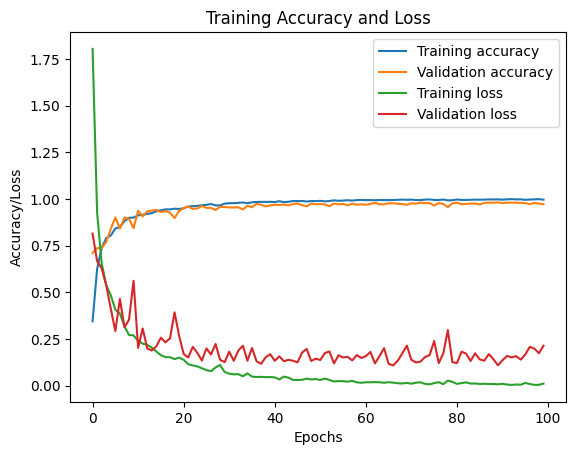

In [ ]:
# 모델 학습
vis = vis_transformer(x_train, y_train_encoded)
history = vis.train_vit_model(save_path='model_vit')

In [ ]:
# 모델 학습 이후에 원-핫 인코딩된 y_train 데이터를 원래 상태로 복원하는 함수
def restore_original_labels(y_encoded, encoder, label_map):
    # 원-핫 인코딩된 데이터를 인덱스로 변환
    y_indices = encoder.inverse_transform(y_encoded)
    # 인덱스를 원래 레이블로 복원
    inverse_label_map = {v: k for k, v in label_map.items()}
    y_restored = np.array([inverse_label_map[idx[0]] for idx in y_indices])
    return y_restored

# 예제: y_train_encoded를 원래 상태로 복원
y_train = restore_original_labels(y_train_encoded, encoder, label_map)

# 종류별로 출력
unique_restored = np.unique(y_train, axis=0)

print("Unique original y_train labels:\n", unique_original)
print("Unique one-hot encoded y_train labels:\n", unique_encoded)
print("Unique restored y_train labels:\n", unique_restored)

# Ensure restored labels match original unique labels
assert np.array_equal(unique_original, unique_restored), "Restored labels do not match original labels"

Unique original y_train labels:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]
Unique one-hot encoded y_train labels:
 [[0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0.]]
Unique restored y_train labels:
 [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]


In [ ]:
# Test 데이터에서 embeddings 추출
test_embeddings = vis.get_embeddings(x_test)

# Train 데이터에서 embeddings 추출
train_embeddings = vis.get_embeddings(x_train)


282/282 [==============================] - 8s 19ms/step


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# labels의 종류 확인
unique_train_labels = np.unique(y_train, axis=0)
unique_test_labels = np.unique(y_test, axis=0)

print("Unique labels in y_train:", unique_train_labels)
print("Unique labels in y_test:", unique_test_labels)

Unique labels in y_train: [[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]]
Unique labels in y_test: [[0 0 0 0 1 0 1 0]
 [0 0 0 1 0 0 1 0]
 [0 0 0 1 1 0 0 0]
 [0 0 1 0 0 0 1 0]
 [0 0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0]
 [0 1 0 1 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [1 0 0 0 0 0 1 0]
 [1 0 0 0 1 0 0 0]
 [1 0 0 1 0 0 0 0]
 [1 0 1 0 0 0 0 0]]


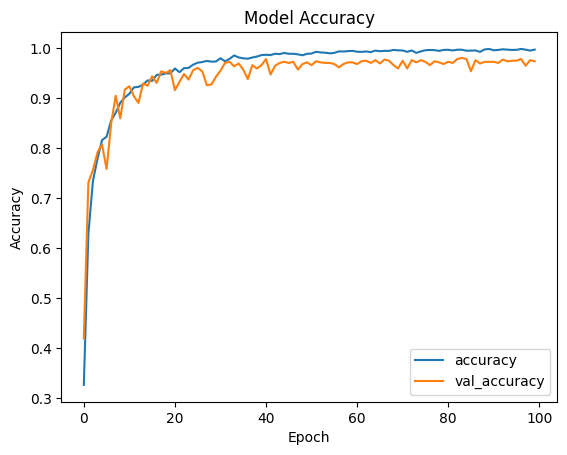

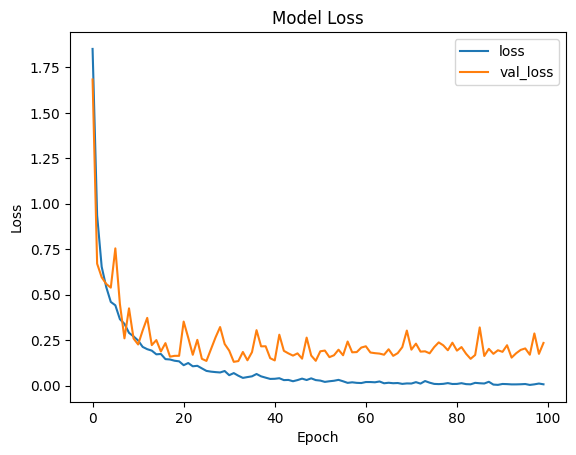

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    # 정확도 그래프
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show() #    plt.plot(history.history['val_accuracy'], label='val_accuracy')


    # 손실 그래프
    plt.plot(history.history['loss'], label='loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(history.history['val_loss'], label='val_loss')

    plt.legend()
    plt.show() #    plt.plot(history.history['val_loss'], label='val_loss')

# 모델 학습 후 히스토리를 사용하여 그래프 그리기
plot_history(history)


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# KNN을 사용한 라벨 예측 및 유사도 계산
predictions_dfs = vis.calculate_knn_similarity(train_embeddings, test_embeddings, y_train, y_test, k=5)

# 예측 결과 엑셀 파일로 저장
vis.save_predictions_to_excel(predictions_dfs, '/content/drive/MyDrive/반도체 캐글_mix/데이터/이중만_8_2/분석_n2/soft_co+eu_predictions')

Predictions saved to /content/drive/MyDrive/반도체 캐글_mix/데이터/이중만_8_2/분석_n2/soft_co+eu_predictions_euclidean.xlsx
Predictions saved to /content/drive/MyDrive/반도체 캐글_mix/데이터/이중만_8_2/분석_n2/soft_co+eu_predictions_cosine.xlsx


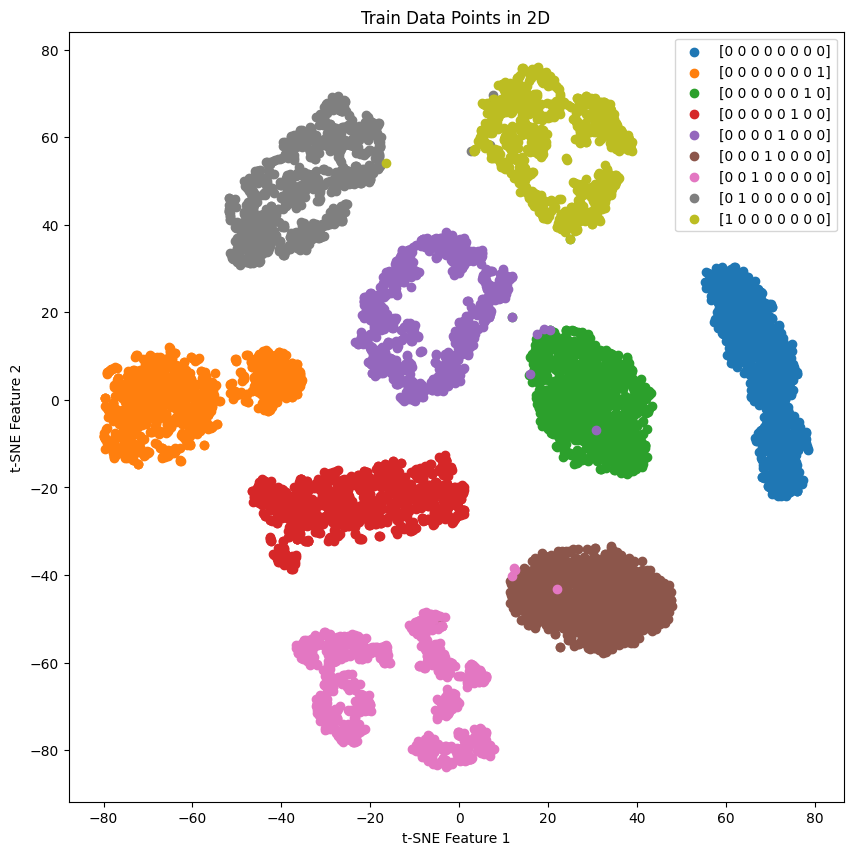

In [ ]:
from sklearn.manifold import TSNE

# 학습 데이터 포인트의 플롯을 출력
def plot_train_data_points(embeddings, y_train):
    # t-SNE로 임베딩 벡터를 2D로 변환
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(y_train, axis=0)

    for label in unique_labels:
        indices = np.where((y_train == label).all(axis=1))
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=str(label))

    plt.legend()
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.title('Train Data Points in 2D')
    plt.show()

# Train 데이터에서 임베딩 추출
#train_embeddings = vis.get_embeddings(x_train)

# 학습 데이터 포인트의 플롯을 출력
plot_train_data_points(train_embeddings, y_train)


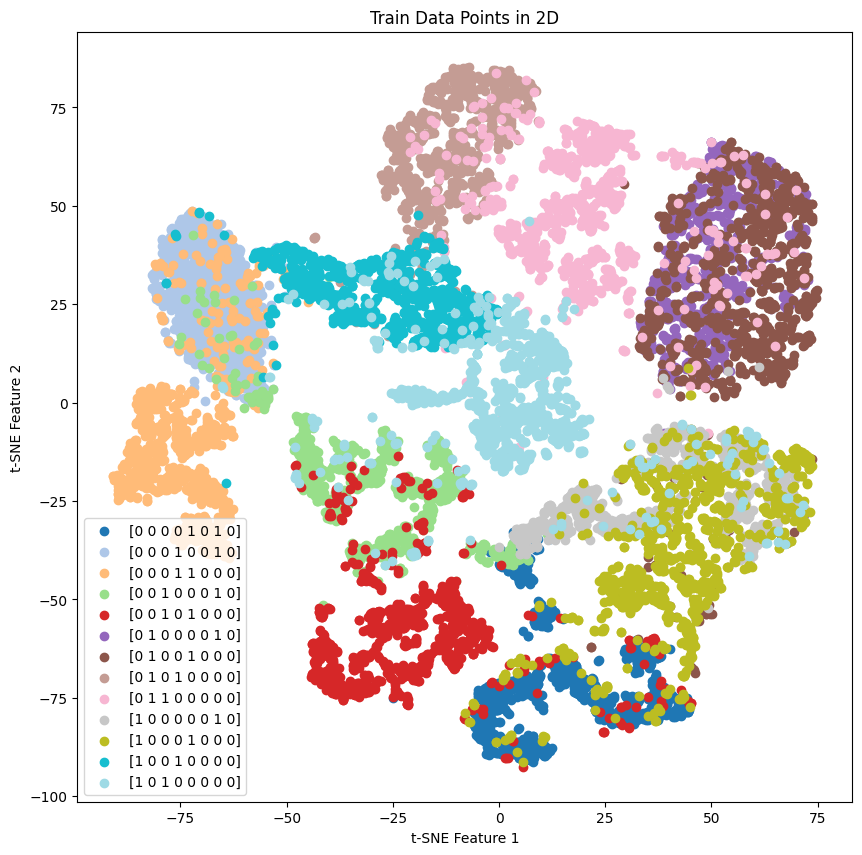

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# 학습 데이터 포인트의 플롯을 출력
def plot_train_data_points(embeddings, y_test):
    # t-SNE로 임베딩 벡터를 2D로 변환
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    unique_labels = np.unique(y_test, axis=0)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        indices = np.where((y_test == label).all(axis=1))
        plt.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], label=str(label), color=color)

    plt.legend()
    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    plt.title('Train Data Points in 2D')
    plt.show()

# Test 데이터에서 임베딩 추출
# test_embeddings = vis.get_embeddings(x_test)

# 학습 데이터 포인트의 플롯을 출력
plot_train_data_points(test_embeddings, y_test)


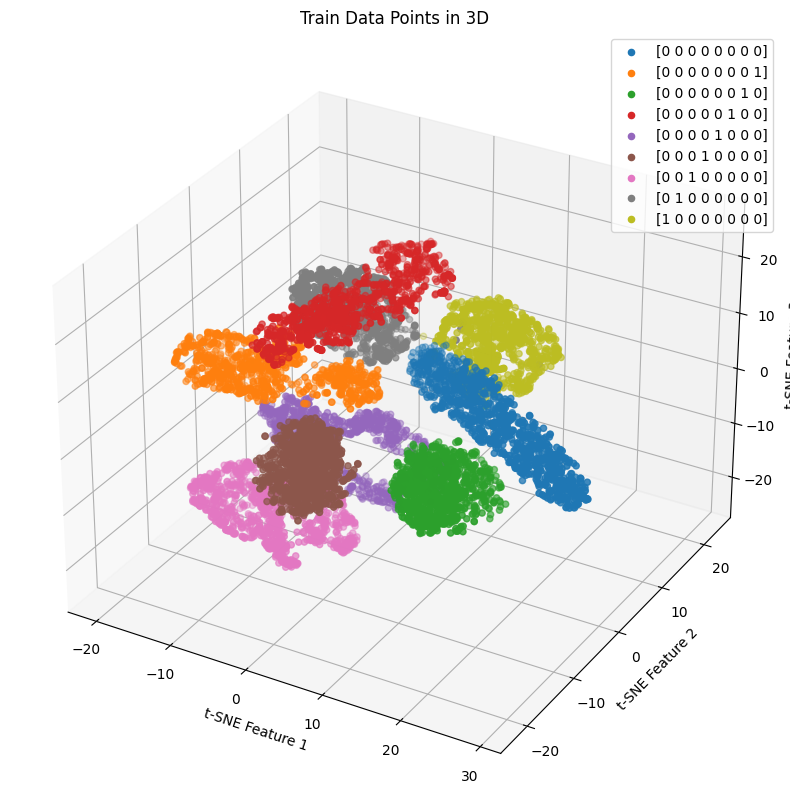

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 학습 데이터 포인트의 플롯을 출력
def plot_train_data_points_3d(embeddings, y_train):
    # t-SNE로 임베딩 벡터를 3D로 변환
    tsne = TSNE(n_components=3, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(y_train, axis=0)

    for label in unique_labels:
        indices = np.where((y_train == label).all(axis=1))
        ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], reduced_embeddings[indices, 2], label=str(label))

    ax.legend()
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_zlabel('t-SNE Feature 3')
    ax.set_title('Train Data Points in 3D')
    plt.show()

# 학습 데이터 포인트의 플롯을 출력
plot_train_data_points_3d(train_embeddings, y_train)

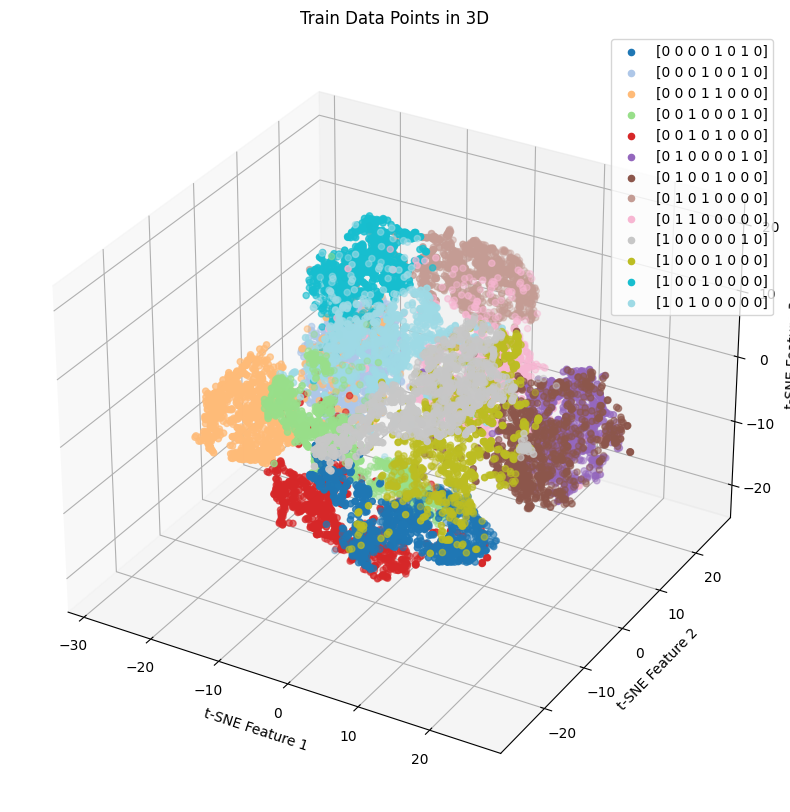

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 학습 데이터 포인트의 플롯을 출력
def plot_test_data_points_3d(embeddings, y_test):
    # t-SNE로 임베딩 벡터를 3D로 변환
    tsne = TSNE(n_components=3, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    unique_labels = np.unique(y_test, axis=0)
    colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

    for label, color in zip(unique_labels, colors):
        indices = np.where((y_test == label).all(axis=1))
        ax.scatter(reduced_embeddings[indices, 0], reduced_embeddings[indices, 1], reduced_embeddings[indices, 2], label=str(label), color=color)

    ax.legend()
    ax.set_xlabel('t-SNE Feature 1')
    ax.set_ylabel('t-SNE Feature 2')
    ax.set_zlabel('t-SNE Feature 3')
    ax.set_title('Train Data Points in 3D')
    plt.show()

# 학습 데이터 포인트의 플롯을 출력
plot_test_data_points_3d(test_embeddings, y_test)


In [ ]:
# Test 데이터에서 embeddings 추출
#test_embeddings = vis.get_embeddings(x_test)

# Train 데이터에서 embeddings 추출
#train_embeddings = vis.get_embeddings(x_train)

# 임베딩 샘플 출력 함수
def print_embeddings_sample(train_embeddings, test_embeddings, y_train, y_test, num_samples=20):
    print("Train Embeddings Sample:")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"Embedding: {train_embeddings[i]}")
        print(f"Label: {y_train[i]}")
        print()

    print("Test Embeddings Sample:")
    for i in range(num_samples):
        print(f"Sample {i+1}:")
        print(f"Embedding: {test_embeddings[i]}")
        print(f"Label: {y_test[i]}")
        print()

# 임베딩과 라벨 샘플 출력
print_embeddings_sample(train_embeddings, test_embeddings, y_train, y_test, num_samples=20)


Train Embeddings Sample:
Sample 1:
Embedding: [-0.16997108 -0.14782076 -0.0258583  ...  0.76274955 -0.16702585
  2.1640413 ]
Label: [0 1 0 0 0 0 0 0]

Sample 2:
Embedding: [ 1.5855731  -0.01308442 -0.07890888 ... -0.1318973   0.3169342
  2.617852  ]
Label: [1 0 0 0 0 0 0 0]

Sample 3:
Embedding: [-0.16509482 -0.13805436 -0.00641114 ...  0.23632851 -0.16993329
  1.5926181 ]
Label: [0 1 0 0 0 0 0 0]

Sample 4:
Embedding: [ 0.77606535 -0.09948992  0.15655732 ... -0.1572355   0.04110346
  0.5697801 ]
Label: [0 0 0 0 1 0 0 0]

Sample 5:
Embedding: [-0.16588284  2.0877514  -0.08166074 ...  0.85401964 -0.10620119
  0.12066796]
Label: [0 0 0 0 0 1 0 0]

Sample 6:
Embedding: [-0.0268157   0.6643121  -0.16001453 ... -0.16874318 -0.05476901
 -0.09078509]
Label: [0 0 0 1 0 0 0 0]

Sample 7:
Embedding: [-0.04771313 -0.16830797 -0.15447354 ... -0.09028501 -0.13511568
 -0.1698839 ]
Label: [0 0 1 0 0 0 0 0]

Sample 8:
Embedding: [ 1.9206139  -0.04792798 -0.16971144 ... -0.03966824  0.01067671
  1.7602

In [ ]:
import numpy as np

# 임베딩 샘플 출력 함수
def print_embeddings_sample(train_embeddings, test_embeddings, y_train, y_test, num_samples_per_label=5):
    unique_labels_train = np.unique(y_train, axis=0)
    unique_labels_test = np.unique(y_test, axis=0)

    print("Train Embeddings Sample:")
    for label in unique_labels_train:
        label_indices = np.where((y_train == label).all(axis=1))[0]
        print(f"Label: {label}")
        for i in range(min(num_samples_per_label, len(label_indices))):
            index = label_indices[i]
            print(f"Sample {i+1}:")
            print(f"Embedding: {train_embeddings[index]}")
            print()

    print("Test Embeddings Sample:")
    for label in unique_labels_test:
        label_indices = np.where((y_test == label).all(axis=1))[0]
        print(f"Label: {label}")
        for i in range(min(num_samples_per_label, len(label_indices))):
            index = label_indices[i]
            print(f"Sample {i+1}:")
            print(f"Embedding: {test_embeddings[index]}")
            print()

# 임베딩과 라벨 샘플 출력
print_embeddings_sample(train_embeddings, test_embeddings, y_train, y_test, num_samples_per_label=5)


Train Embeddings Sample:
Label: [0 0 0 0 0 0 0 0]
Sample 1:
Embedding: [-0.14896607 -0.1198172   0.68052405 ... -0.0867496   1.1226397
 -0.13882236]

Sample 2:
Embedding: [-0.16939032 -0.14698206  0.37215075 ... -0.16989072  1.1312407
 -0.16993709]

Sample 3:
Embedding: [-0.15937221 -0.0925208   1.8572408  ... -0.04562359  0.88364935
 -0.16497122]

Sample 4:
Embedding: [-0.13869278 -0.08950523  2.128491   ... -0.06062683  0.93903315
 -0.16279006]

Sample 5:
Embedding: [-0.15011904 -0.14586633  2.0031915  ... -0.01743994  0.66825646
 -0.1655727 ]

Label: [0 0 0 0 0 0 0 1]
Sample 1:
Embedding: [-0.02980907 -0.16942453 -0.03767451 ... -0.13658708 -0.12949374
  2.803911  ]

Sample 2:
Embedding: [-0.13962224  0.3089812  -0.09554232 ... -0.16329807 -0.13569984
  0.67147535]

Sample 3:
Embedding: [-0.16073322 -0.16664399 -0.12107141 ... -0.16985738 -0.07553981
  1.2962174 ]

Sample 4:
Embedding: [-0.10883949  0.00477491 -0.11832537 ... -0.1581401  -0.10752421
  1.652718  ]

Sample 5:
Embeddin

    def calculate_similarity(self, train_embeddings, test_embeddings):
        similarities = np.dot(test_embeddings, train_embeddings.T)
        return similarities

    def calculate_cosine_similarity(self, train_embeddings, test_embeddings):
        train_norms = np.linalg.norm(train_embeddings, axis=1)
        test_norms = np.linalg.norm(test_embeddings, axis=1)
        similarities = np.dot(test_embeddings, train_embeddings.T) / np.outer(test_norms, train_norms)
        return similarities

    def calculate_euclidean_similarity(self, train_embeddings, test_embeddings):
        distances = np.sqrt(((test_embeddings[:, np.newaxis, :] - train_embeddings) ** 2).sum(axis=2))
        similarities = -distances  # Convert distance to similarity by negating
        return similarities

    def save_similarities_to_excel(self, similarities, filename):
        df = pd.DataFrame(similarities)
        df.to_excel(filename, index=False)
        print(f"Similarities saved to {filename}")

# 각 테스트 데이터 포인트에 대해 각 라벨별로 최대 유사도 계산
predictions_df = vis.calculate_max_similarity_per_label(train_embeddings, test_embeddings, y_train, y_test)
save_predictions_to_excel(predictions_df, '/content/drive/MyDrive/반도체 캐글_mix/데이터/이중만_8_2/분석_n2/eu+co_max_similarities_per_label.xlsx')

# 임베딩과 라벨을 pickle 파일로 저장
def save_embeddings_and_labels(train_embeddings, test_embeddings, y_train, y_test, filename):
    data = {
        'train_embeddings': train_embeddings,
        'test_embeddings': test_embeddings,
        'y_train': y_train,
        'y_test': y_test
    }
    with open(filename, 'wb') as f:
        pickle.dump(data, f)
    print(f"Embeddings and labels saved to {filename}")

# 파일 경로 설정
pickle_filename = '/content/drive/MyDrive/반도체 캐글_mix/데이터/이중만_8_2/분석_n2/soft_eu+co_전체_embeddings_and_labels.pkl'

# 임베딩과 라벨 저장
save_embeddings_and_labels(train_embeddings, test_embeddings, y_train, y_test, pickle_filename)

import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances

# Euclidean distance를 사용하여 유사도 계산 및 엑셀 저장 함수
def calculate_max_similarity_per_label(train_embeddings, test_embeddings, y_train, y_test):
    # Euclidean distances 계산
    similarities = - euclidean_distances(test_embeddings, train_embeddings)

    max_similarities = []

    for i, test_embed in enumerate(test_embeddings):
        max_similarity = {}
        for label in np.unique(y_train, axis=0):
            label_indices = np.where((y_train == label).all(axis=1))[0]
            if len(label_indices) > 0:
                label_similarities = similarities[i, label_indices]
                max_similarity[np.array2string(label, separator=' ')] = np.max(label_similarities)
            else:
                max_similarity[np.array2string(label, separator=' ')] = None

        max_similarities.append({
            'Test Index': i,
            'Actual Label': np.array2string(y_test[i], separator=' '),
            **max_similarity
        })

    return pd.DataFrame(max_similarities)

def save_predictions_to_excel(predictions_df, filename):
    predictions_df.to_excel(filename, index=False)
    print(f"Predictions saved to {filename}")

# 각 테스트 데이터 포인트에 대해 각 라벨별로 최대 유사도 계산

# 예측 결과를 엑셀 파일로 저장
predictions_df = calculate_max_similarity_per_label(train_embeddings, test_embeddings, y_train, y_test)
save_predictions_to_excel(predictions_df, '/content/drive/MyDrive/반도체 캐글_mix/데이터/이중만_8_2/분석_n2/eu+co_max_similarities_per_label.xlsx')
